German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Arias, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020  
Vesion : 1.2.1

## Episode 2 : First Convolutions

Our main steps:
 - Read H5 dataset
 - Build a model
 - Train the model
 - Evaluate the model

## 1/ Import and init

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time

import idle.pwk as ooo
from importlib import reload

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.4
  Run time           : Thursday 16 January 2020, 16:26:01
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-24x24-L

In [3]:
%%time

def read_dataset(name):
    '''Reads h5 dataset from ./data

    Arguments:  dataset name, without .h5
    Returns:    x_train,y_train,x_test,y_test data'''
    # ---- Read dataset
    filename='./data/'+name+'.h5'
    with  h5py.File(filename) as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]

    # ---- done
    print('Dataset "{}" is loaded. ({:.1f} Mo)\n'.format(name,os.path.getsize(filename)/(1024*1024)))
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = read_dataset('set-24x24-L')

Dataset "set-24x24-L" is loaded. (228.8 Mo)

CPU times: user 0 ns, sys: 344 ms, total: 344 ms
Wall time: 463 ms


## 3/ Have a look to the dataset
We take a quick look as we go by...

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


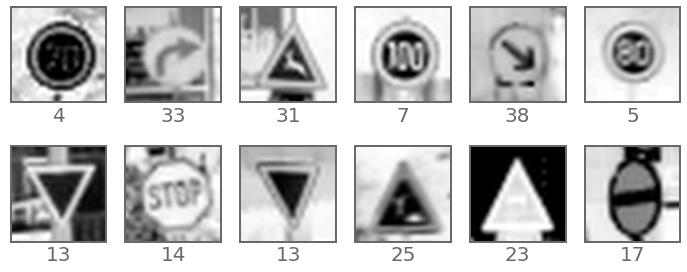

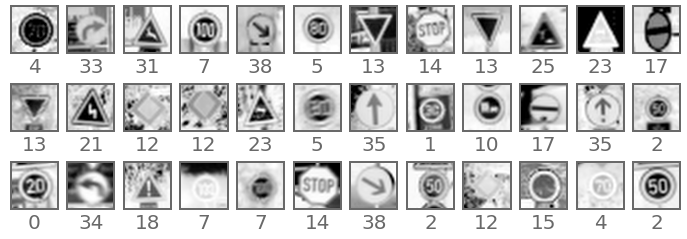

In [4]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

ooo.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2)
ooo.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1)

## 4/ Create model
We will now build a model and train it...

Some models :

In [5]:

# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# My sphisticated model, but small and fast
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## 5/ Train the model
**Get the shape of my data :**

In [6]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [8]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 22, 22, 96)        960       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 192)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)             

**Train it :**

In [9]:
%%time

batch_size = 64
epochs     = 5

# ---- Shuffle train data
x_train,y_train=ooo.shuffle_np_dataset(x_train,y_train)

# ---- Train
history = model.fit(  x_train[:2000], y_train[:2000],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))

Train on 2000 samples, validate on 12630 samples
Epoch 1/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 3.5544 - accuracy: 0.0640 - val_loss: 3.4370 - val_accuracy: 0.0924
Epoch 2/5
2000/2000 [==============================] - 2s 900us/sample - loss: 3.3254 - accuracy: 0.1140 - val_loss: 3.1923 - val_accuracy: 0.1568
Epoch 3/5
2000/2000 [==============================] - 2s 903us/sample - loss: 2.8077 - accuracy: 0.2880 - val_loss: 2.5395 - val_accuracy: 0.3308
Epoch 4/5
2000/2000 [==============================] - 2s 880us/sample - loss: 2.1190 - accuracy: 0.4425 - val_loss: 1.8869 - val_accuracy: 0.5202
Epoch 5/5
2000/2000 [==============================] - 2s 909us/sample - loss: 1.5545 - accuracy: 0.5655 - val_loss: 1.5202 - val_accuracy: 0.5954
CPU times: user 2min 27s, sys: 14.4 s, total: 2min 41s
Wall time: 10.9 s


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.5954


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 1.5202
Test accuracy  : 0.5954


## 6/ Multiple datasets, multiple models ;-)

In [ ]:
%%time

batch_size = 64
epochs     = 16

datasets = ['set-24x24-L', 'set-24x24-RGB', 'set-48x48-L', 'set-48x48-RGB', 'set-24x24-L-LHE', 'set-24x24-RGB-HE', 'set-48x48-L-LHE', 'set-48x48-RGB-HE']
models   = {'v1':get_model_v1, 'v2':get_model_v2, 'v3':get_model_v3}
# datasets = ['set-24x24-L', 'set-24x24-RGB']
# models   = {'v1':get_model_v1, 'v3':get_model_v3}

report=[]
head=['Datasets', 'Size']
head.extend( [ 'Model : {} '.format(i) for i in models.keys()] )
report.append('|'+'|'.join(head)+'|')
report.append('|:-----:'*len(head)+'|')

for dname in datasets:
    print()
    # ---- Read dataset
    x_train,y_train,x_test,y_test = read_dataset(dname)
    dsize=os.path.getsize('./data/'+dname+'.h5')/(1024*1024)
    
    # ---- Get the shape
    (n,lx,ly,lz) = x_train.shape

    # ---- For each model
    accuracy={}
    duration={}
    for kmodel,fmodel in models.items():
        print("    Run model : {}  : ".format(kmodel), end='')
        # ---- get model
        try:
            model=fmodel(lx,ly,lz)
            # ---- Compile it
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            # ---- Train
            start_time = time.time()
            history = model.fit(  x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=0,
                                validation_data=(x_test, y_test))
            # ---- Result
            end_time= time.time()
            accuracy[kmodel] = '{:6.2f}%'.format(100*max(history.history["val_accuracy"]))
            duration[kmodel] = '{:6.2f}s'.format( (end_time-start_time) )
            print("Done with : {} in {}".format(accuracy[kmodel],duration[kmodel]))
        except:
            accuracy[kmodel] = '  -   '
            duration[kmodel] = '  -   '
            print('Cannot be use..')
    # ---- Output
    results='|'.join( [ ' {} {} '.format(accuracy[i], duration[i]) for i in accuracy.keys()] )
    report.append( '| {:24s} | {:12.0f} Mo | {} |'.format(dname, dsize, results ) )

print('\n\nFinal report is :\n')
print('\n'.join(report))

---


### Some results :  



|         Datasets         |       Size      |     Model : v1     |    Model : v2      |     Model : v3     |
|:------------------------:|:---------------:|:------------------:|:------------------:|:------------------:|
| set-24x24-L              |          229 Mo |   95.91%  75.04s   |   96.86% 102.28s   |   -      -         |
| set-24x24-RGB            |          684 Mo |   96.60%  77.24s   |   97.32% 103.93s   |   -      -         |
| set-48x48-L              |          914 Mo | **96.71%** 123.94s |   97.68% 149.57s   |  97.60%  91.53s    |
| set-48x48-RGB            |         2736 Mo |   96.36% 117.74s   | **98.20%** 142.63s |  97.28%  91.29s    |
| set-24x24-L-LHE          |          229 Mo |   95.95%  66.12s   |   96.75%  89.45s   |   -      -         |
| set-24x24-RGB-HE         |          684 Mo |   95.30%  68.89s   |   96.28%  92.15s   |   -      -         |
| set-48x48-L-LHE          |          914 Mo |   96.69% 109.28s   |   97.94% 135.17s   | **97.97%** 83.80s  |
| set-48x48-RGB-HE         |         2736 Mo |   95.29% 117.70s   | **98.13%** 141.56s |  97.00%  89.38s    |

In [1]:
import pandas as pd

In [10]:
data = {'Dataset':  ['set-24x24-L', 'set-24x24-RGB', 'set-48x48-L'],
        'Size': [229,684,914],
        'v1 Accuracy': [95.91, 96.60, 96.71],
        'v1 Duration': [75.04, 77.24, 123.94]
        }
df = pd.DataFrame (data)
print(df)

# A faire : pretty print, ajout multi_run dans pwk

         Dataset  Size  v1 Accuracy  v1 Duration
0    set-24x24-L   229        95.91        75.04
1  set-24x24-RGB   684        96.60        77.24
2    set-48x48-L   914        96.71       123.94
